In [1]:
import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import sys
import pandas as pd
import numpy as np
from Bio.Seq import Seq
import statistics
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
from Bio import Entrez
from Bio import SeqIO
Entrez.email= "pavel-kravchenk0@yandex.ru"
from Bio.SeqUtils import GC
from time import clock
from dna_features_viewer import GraphicFeature, GraphicRecord, CircularGraphicRecord
from dna_features_viewer import BiopythonTranslator
import subprocess
import random
from random import randrange 
import argparse
from itertools import groupby
import itertools
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Alphabet import IUPAC, Gapped
from Bio import Phylo
from Bio.Align.Applications import ClustalwCommandline
from sys import argv
from Bio import AlignIO
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from scipy import stats
from __future__ import print_function, division
import matplotlib.pyplot as plt
from IPython.core import page
page.page = print
import networkx as nx
from skbio import DNA, TabularMSA
import skbio.io
from skbio.alignment import local_pairwise_align_ssw, global_pairwise_align_nucleotide
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Data import CodonTable
from fuzzywuzzy import fuzz
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.codonalign.codonseq import _get_codon_list, CodonSeq, cal_dn_ds
from Bio.codonalign.codonalphabet import (default_codon_table, default_codon_alphabet)
from statistics import mean 

/home/pavel/anaconda3/lib/python3.6/site-packages/Bio/codonalign/__init__.py:27: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [158]:
# MOTS-C
gene_global = ["RNR1", "rnr1"]
feature_type_global = "rRNA"
product_global = ["12S ribosomal RNA", "s-rRNA", "small subunit ribosomal RNA"]
consensus_seq = "RRVKVPMRWQEMGYIFYPRKLRPLNLRVEGGFSSKLRVE"
strand_global = 1

'''
# Humanin +
gene_global = ["RNR2", "rnr2"]
feature_type_global = "rRNA"
product_global = ["16S ribosomal RNA", "l-rRNA", "large subunit ribosomal RNA"]
consensus_seq = "TLTVQRHNHLFLK-GLVMAPRGFSCLLLLTSEIDLPVKRR"
strand_global = 1

#Gau

gene_global = ["COX1", "cox1", "cox1/2"]
feature_type_global = "CDS"
consensus_seq = "MMTGWPKNQNKCWYKMGSPPPAGSKKVVLLRSVNNMVMPAA"
product_global = ["cytochrome c oxidase subunit I", "COX1", "cox1", "cytochrome oxidase subunit 1 and subunit 2", "cytochrome c oxidase subunit 1"]
strand_global = -1
'''

genetic_code_table_id = 1


def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")
    
    
class FEATURE:
    def __init__(self, gene = None, coordinates = None, strand = None, feature_type = None, codon_start = None, product = None, protein_id = None, translation = None, transl_table = None, note = None):
        self.gene = gene
        self.coordinates = coordinates
        self.strand = strand
        self.feature_type = feature_type
        self.product = product
        self.codon_start = codon_start
        self.product = product
        self.protein_id = protein_id
        self.translation = translation
        self.transl_table = transl_table
        self.note = note
        
        
    def __str__(self):
        out = "gene --- {gene} \n coordinates --- {coordinates} \n strand --- {strand} \n feature_type --- {feature_type} \n codon_start --- {codon_start} \n product --- {product} \n protein_id --- {protein_id} \n translation --- {translation} \n transl_table --- {transl_table} \n note --- {note} \n".format(gene=self.gene,
        coordinates=self.coordinates, 
        strand=self.strand, 
        feature_type=self.feature_type, 
        product=self.product, 
        codon_start=self.codon_start, 
        protein_id=self.protein_id, 
        translation=self.translation, 
        transl_table=self.transl_table,
        note = self.note)
        return out


class GB_RECORD:
    def __init__(self, ID = None, Len = None, seq_type = None, 
                 definition = None, organism = None, features = None, 
                 sequence = None, rev_comp_sequence = None, feature_count = None):
        self.ID = ID
        self.Len = Len
        self.seq_type = seq_type
        self.definition = definition
        self.organism = organism
        self.features = features
        self.sequence = sequence
        self.rev_comp_sequence = rev_comp_sequence
        self.feature_count = feature_count
        #print(self.ID,self.Len,self.seq_type,self.definition,self.organism,self.sequence)
        
    def __str__(self):
        out = "ID --- {ID} \t Len --- {Len} \t seq_type --- {seq_type} \n definition --- {definition} \n organism --- {organism} \n sequence --- {sequence} \n rev_comp_sequence --- {rev_comp_sequence} \n feature_count --- {feature_count} \n".format(ID=self.ID,
        Len=self.Len,
        seq_type=self.seq_type,
        definition=self.definition,
        organism=self.organism,
        sequence=self.sequence[:100],
        rev_comp_sequence=self.rev_comp_sequence[:100], 
        feature_count=self.feature_count)
        
        #out = ""
        for i in range(self.feature_count):
            out += str(self.features[i])
        return out
        

files_gb = [f for f in os.listdir("./data/") if os.path.splitext(f)[1] == '.gb'] 
print("Input files ... ")
#[print(x) for x in files_gb]
print(len(files_gb))
print("")

gb_record_list = []
for file in files_gb:
    #print(file)
    record = SeqIO.read("./data/" + file, "genbank")
    print(record.annotations["organism"])
    
    c = 0
    FEATURE_count = 0
    FEATURE_dict = {}
    for feature in record.features:
        
        product = None
        note = None
        codon_start = None
        protein_id = None
        translation = None
        start = None
        end = None
        strand = None
        feature_type = None
        gene = None
        transl_table = None
        

        #print(feature.qualifiers)   
        if "'product'" in str(feature.qualifiers):
            product = str(feature.qualifiers['product'])[2:-2]
            #print(product)
        if "'gene'" in str(feature.qualifiers):
            gene = str(feature.qualifiers['gene'])[2:-2]
            #print(gene)
        if "'note'" in str(feature.qualifiers):
            note = str(feature.qualifiers['note'])[2:-2]
            #print(note)   
        if "'codon_start'" in str(feature.qualifiers):
            codon_start = str(feature.qualifiers['codon_start'])[2:-2]   
            #print(codon_start)                     
        if "'protein_id'" in str(feature.qualifiers):
            protein_id = str(feature.qualifiers['protein_id'])[2:-2]   
            #print(protein_id) 
        if "'translation'" in str(feature.qualifiers):
            translation = str(feature.qualifiers['translation'])[2:-2]   
            #print(translation) 
        if "'transl_table'" in str(feature.qualifiers):
            transl_table = str(feature.qualifiers['transl_table'])[2:-2]   
            #print(translation) 
            
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = feature.strand
        feature_type = feature.type
        
        FEATURE_dict[FEATURE_count] = FEATURE(gene, [start, end], strand, feature_type, codon_start, product, protein_id, translation, transl_table, note)
        #print(FEATURE_dict[FEATURE_count])
        FEATURE_count += 1

    GB_RECORD_tmp = GB_RECORD(record.id, len(record.seq), record.annotations["molecule_type"], record.description, record.annotations["organism"], FEATURE_dict, str(record.seq), str(record.reverse_complement()), FEATURE_count)
    gb_record_list.append(GB_RECORD_tmp)

    


c = 0
if feature_type_global == "CDS":
    file_fasta_aa = "processed_aa_cut_" + feature_type_global + ".fasta"
    with open(file_fasta_aa, "w") as out_file:
        for gb_record in gb_record_list:
            #print(gb_record.organism)
            for feature in list(gb_record.features.keys()):
                #print(gb_record.features[feature])
                #print(gb_record.features[feature].feature_type, gb_record.features[feature].gene)
                if gb_record.features[feature].gene in gene_global and gb_record.features[feature].feature_type == feature_type_global or gb_record.features[feature].product in product_global:
                    print(gb_record.organism)
                    #print(str(gb_record.features[feature].translation))
                    out_file.write(">" + "_".join(gb_record.organism.split(" ")).replace("'", "") + "_" + str(c) + "\n")
                    module_fasta_writer(out_file, gb_record.features[feature].translation)
                    c += 1
                    
    p = subprocess.Popen("clustalw {file}".format(file=file_fasta_aa), shell=True)
    p.wait()
    #tree = Phylo.read(file_fasta_aa.split(".")[0] + ".dnd", 'newick')
    #Phylo.draw_ascii(tree)
    print("Done 1 !")
print(c) 


print("")    
c = 0
file_fasta_aa_rev = "processed_nt_to_aa_rev_comp_cut_" + feature_type_global + ".fasta"
file_fasta_nt_rev = "processed_nt_to_nt_rev_comp_cut_" + feature_type_global + ".fasta"
file_fasta_nt = "processed_nt_to_nt_cut_" + feature_type_global + ".fasta"


with open(file_fasta_aa_rev, "w") as out_file_aa:
    with open(file_fasta_nt_rev, "w") as out_file_nt:
        with open(file_fasta_nt, "w") as out_file:
            for gb_record in gb_record_list:
                for feature in list(gb_record.features.keys()):
                    #print(gb_record.features[feature].gene, gb_record.features[feature].feature_type)
                    if (gb_record.features[feature].gene in gene_global and gb_record.features[feature].feature_type == feature_type_global) or gb_record.features[feature].product in product_global:
                        #print(gb_record.organism)

                        start = int(gb_record.features[feature].coordinates[0])
                        stop = int(gb_record.features[feature].coordinates[1])

                        #print(gb_record.sequence)
                        if gb_record.features[feature].strand == 1:
                            sequence = Seq(str(gb_record.sequence), generic_dna)
                            sub_seq = sequence[start:stop]
                            print("1")

                        #print(gb_record.rev_comp_sequence)
                        if gb_record.features[feature].strand == -1:
                            sequence = Seq(str(gb_record.sequence), generic_dna)
                        
                            #print(sequence)
                            sub_seq = sequence[start:stop]
                            sequence = Seq(str(gb_record.sequence), generic_dna).reverse_complement()
                            
                            print("-1")  
                            #print(sub_seq)

                        #print(sub_seq)
                        out_file.write(">" + "_".join(gb_record.organism.split(" ")).replace("'", "") + "_" + str(c) + "\n")
                        module_fasta_writer(out_file, str(sub_seq))
                        
                        if strand_global == -1:
                            sub_seq = sub_seq.reverse_complement()

                        #print(sub_seq)
                        frame_dict = {}
                        for frame in range(3):
                            #print(frame)
                            sub_seq_aa = sub_seq[frame:].translate(table=genetic_code_table_id, to_stop=False) #, stop_symbol="❤"
                            Partial_Ratio = fuzz.partial_ratio(sub_seq_aa.lower(), consensus_seq.lower())

                            #print(Partial_Ratio)
                            frame_dict[Partial_Ratio] = frame

                        #print("max is", frame_dict[max(list(frame_dict.keys()))])    
                        #print("")
                        sub_seq_aa = sub_seq[frame_dict[max(list(frame_dict.keys()))]:].translate(table=genetic_code_table_id, to_stop=False)   

                        out_file_aa.write(">" + "_".join(gb_record.organism.split(" ")).replace("'", "") + "_" + str(c) + "\n")
                        module_fasta_writer(out_file_aa, str(sub_seq_aa))

                        out_file_nt.write(">" + "_".join(gb_record.organism.split(" ")).replace("'", "") + "_" + str(c) + "\n")
                        module_fasta_writer(out_file_nt, str(sub_seq))
                        c += 1

print(c)   
print("")


p = subprocess.Popen("clustalw {file}".format(file=file_fasta_aa_rev), shell=True)
p.wait()
#tree = Phylo.read(file_fasta_aa_rev.split(".")[0] + ".dnd", 'newick')
#Phylo.draw_ascii(tree)

p = subprocess.Popen("clustalw {file}".format(file=file_fasta_nt_rev), shell=True)
p.wait()
#tree = Phylo.read(file_fasta_nt_rev.split(".")[0] + ".dnd", 'newick')
#Phylo.draw_ascii(tree)

p = subprocess.Popen("clustalw {file}".format(file=file_fasta_nt), shell=True)
p.wait()
#tree = Phylo.read(file_fasta_nt_rev.split(".")[0] + ".dnd", 'newick')
#Phylo.draw_ascii(tree)

print("Done 2 !")


Input files ... 
72

Papio anubis
Lingula anatina
Finch circovirus
Lepisosteus oculatus
Saprolegnia ferax
Homo sapiens subsp. 'Denisova'
Phascolarctos cinereus
Pan troglodytes ellioti
Crassostrea gigas
Branchiostoma belcheri
Borreliella burgdorferi B31
Mizuhopecten yessoensis
Pan paniscus
Macaca fascicularis
Hydra vulgaris
Brucella melitensis bv. 1 str. 16M
Monodelphis domestica
Helicobacter pylori 26695
Caenorhabditis elegans
Rana catesbeiana
Macaca mulatta
Aplysia californica
Leucoraja erinacea
Tetranychus urticae
Mus musculus
Carlito syrichta
Homo sapiens
Arabidopsis thaliana
Salmonella enterica subsp. enterica serovar Typhi str. CT18
Rattus norvegicus
Pseudomonas aeruginosa PAO1
Propithecus coquereli
Rhincodon typus
Python bivittatus
Crocodylus porosus
Homo sapiens neanderthalensis
Neisseria gonorrhoeae FA 1090
Gorilla gorilla gorilla
Plasmodium malariae
Equus asinus
Ornithorhynchus anatinus
Brucella melitensis bv. 1 str. 16M
Priapulus caudatus
Pomacea canaliculata
Saccoglossus kow

/home/pavel/anaconda3/lib/python3.6/site-packages/Bio/Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


Done 2 !


In [ ]:
alignment = AlignIO.read("/home/pavel/Desktop/ORF_SMTB/ORF_finder/processed_nt_to_aa_rev_comp_cut_CDS.aln", "clustal")

def find_match(alignment):
    positions = []
    for al_seq in range(len(alignment)):
        names = [str(alignment[al_seq])[i:i+len(consensus_seq)] for i in range(0, len(alignment[al_seq]) - len(consensus_seq))]
        #best_match = max(names, key=lambda name: fuzz.partial_ratio(consensus_seq, name))
        best_match = process.extractOne(consensus_seq, names)
        match = str(alignment[al_seq]).find(best_match[0])
        
        positions.append(match)
        
    #print(len(alignment))
    match = max(set(positions), key=positions.count)
    alignment = alignment[:, match-20:match+len(consensus_seq)+20]
    #print(len(alignment))
    return alignment
    
alignment_consensus_file = file_fasta_nt_rev.split(".")[0] + "_alignment_consensus.fasta"
with open(alignment_consensus_file, "w") as handle:
    count = SeqIO.write(find_match(alignment), handle, "fasta")
    
p = subprocess.Popen("clustalw {file}".format(file=alignment_consensus_file), shell=True)
p.wait()
tree = Phylo.read(alignment_consensus_file.split(".")[0] + ".dnd", 'newick')
Phylo.draw_ascii(tree)


In [ ]:

def gap_cleaner(alignment):
    sub_alignment = ""
    
    for i in range(0, len(alignment[0]), 3):
        codon_slice =  alignment[:,i:i+3]
        #print(codon_slice)
        
        if "-" not in codon_slice[:,0] and "-" not in codon_slice[:,1] and "-" not in codon_slice[:,2] and "N" not in codon_slice[:,0] and "N" not in codon_slice[:,1] and "N" not in codon_slice[:,2] and len(codon_slice[0]) == 3:
            if  sub_alignment == "":
                sub_alignment = codon_slice
            else:
                sub_alignment += codon_slice
    return sub_alignment

def dnds(alignment):
    result_collector = []
    sub_alignment = gap_cleaner(alignment)

    if sub_alignment != "":
        for i in range(len(sub_alignment)):
            #print(i, "i")
            for j in range(len(sub_alignment)):
                if i < j:
                    #print(j)
                    seq1 = str(sub_alignment[i].seq)
                    seq2 = str(sub_alignment[j].seq)
                    #print(seq1, seq2)
                    seq1 = SeqRecord(CodonSeq(seq1, alphabet=default_codon_alphabet), id="seq1")
                    seq2 = SeqRecord(CodonSeq(seq2, alphabet=default_codon_alphabet), id="seq2")
                    #print(seq1, seq2)
                    dN, dS = cal_dn_ds(seq1, seq2, method="ML")
                    #print(dN/dS)
                    result_collector.append(dN/dS)

    return mean(result_collector)

alignment = AlignIO.read("/home/pavel/Desktop/ORF_SMTB/ORF_finder/processed_nt_to_nt_rev_comp_cut_CDS.aln", "clustal")
print(dnds(alignment))

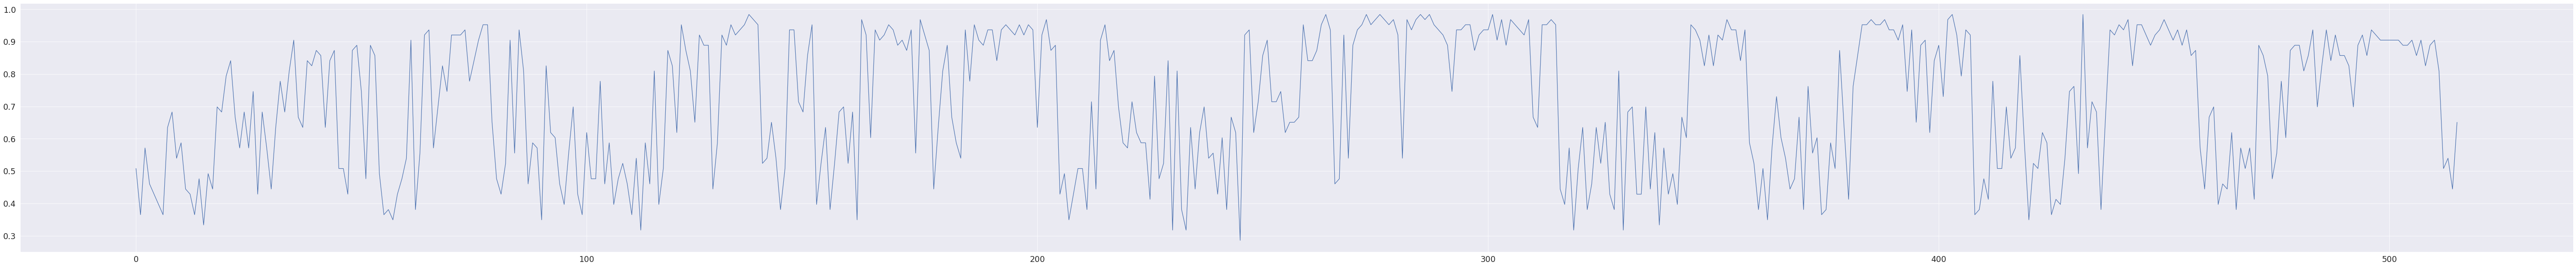

In [144]:
def gap_cleaner(alignment, threshold):
    sub_alignment = []
    
    for i in range(0, len(alignment[0]), 3):
        col_slice =  alignment[:,i]
        #print(codon_slice)
        
        gap_count = round(col_slice.count('-')/len(col_slice), round_param)
        #print(gap_count)
        
        if gap_count < threshold:
                sub_alignment.append(col_slice)
    return sub_alignment


def mutation_rate(alignment, threshold):
    result_collector = []

    sub_alignment = gap_cleaner(alignment, threshold)
    #print(sub_alignment[1])
    
    for col_slice in sub_alignment:
        A_freq = col_slice.count('A')/len(col_slice)
        T_freq = col_slice.count('T')/len(col_slice)
        G_freq = col_slice.count('G')/len(col_slice)
        C_freq = col_slice.count('C')/len(col_slice)
        result_collector.append(max(A_freq, T_freq, G_freq, C_freq))
    return result_collector

round_param = 4        
threshold = 0.25

#print(mutation_rate(alignment, threshold))
y = mutation_rate(alignment, threshold)
x = [x for x in range(len(y))]

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(100, 10)
sns.set_context("paper", font_scale=2)
                          
plt.plot(x ,y)

In [2]:
gap_threshold = 0.25
round_param = 4

def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")
    

def gap_cleaner(alignment, gap_threshold, codon_position):
    sub_alignment = []
    
    for i in range(0, len(alignment[0])-3, 3):
        col_slice =  alignment[:,i:i+3]
        col_slice = col_slice[:,codon_position]
        #print(col_slice)
        
        gap_count = round(col_slice.count('-')/len(col_slice), round_param)
        #print(gap_count)
        
        if gap_count < gap_threshold:
                sub_alignment.append(col_slice)
    return sub_alignment


def mutation_rate(alignment, file_name, gap_threshold):
    for codon_position in range(3):
        print(codon_position)
        
        result_collector = []
        sub_alignment = gap_cleaner(alignment, gap_threshold, codon_position)
        #print(sub_alignment[1])

        for col_slice in sub_alignment:
            A_freq = col_slice.count('A')/len(col_slice)
            T_freq = col_slice.count('T')/len(col_slice)
            G_freq = col_slice.count('G')/len(col_slice)
            C_freq = col_slice.count('C')/len(col_slice)
            result_collector.append(max(A_freq, T_freq, G_freq, C_freq))
            
        y = result_collector
        x = [x for x in range(len(y))]

        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(100, 10)
        sns.set_context("paper", font_scale=2)
        plt.ylim(0,1)
        plt.xlim(0,len(x))
        plt.title("Conservative landscape for position {codon_position}".format(codon_position=codon_position))
        plt.xlabel('Position')
        plt.ylabel('Conservativity')

        plt.plot(x ,y)
        plt.savefig('{file_name}_conservative_landscape_position_{codon_position}.pdf'.format(file_name=file_name.split(".")[0], codon_position=codon_position), dpi=200)
        plt.gcf().clear()
        #plt.show()
        
        
def consensus_cutter(consensus_seq, file_name):
    try:
        alignment = AlignIO.read(file_name, "clustal")
        for al_seq in range(len(alignment)):
            if alignment[al_seq].description == "template":
                #print(alignment[al_seq])
                names = [str(alignment[al_seq].seq)[i:i+len(consensus_seq)] for i in range(0, len(alignment[al_seq].seq) - len(consensus_seq))]
                best_match = process.extractOne(consensus_seq, names)
                #print(best_match)
                match = str(alignment[al_seq].seq).find(best_match[0])
                #print(match)
                alignment = alignment[:, match-10:match + len(consensus_seq) + 10]


        alignment_consensus_file = file_name.split(".")[0] + "_alignment_consensus.fasta"
        
        with open(alignment_consensus_file, "w") as handle:
            count = SeqIO.write(alignment, handle, "fasta")
        return alignment, alignment_consensus_file
    except ValueError:
        return -1
    


def view_alignment(aln, fontsize="9pt", plot_width=800):
    """Bokeh sequence alignment view"""

    #make sequence and id lists from the aln object
    seqs = [rec.seq for rec in (aln)]
    ids = [rec.id for rec in aln]    
    text = [i for s in list(seqs) for i in s]
    colors = get_colors(seqs)    
    N = len(seqs[0])
    S = len(seqs)    
    width = .4

    x = np.arange(1,N+1)
    y = np.arange(0,S,1)
    #creates a 2D grid of coords from the 1D arrays
    xx, yy = np.meshgrid(x, y)
    #flattens the arrays
    gx = xx.ravel()
    gy = yy.flatten()
    #use recty for rect coords with an offset
    recty = gy+.5
    h= 1/S
    #now we can create the ColumnDataSource with all the arrays
    source = ColumnDataSource(dict(x=gx, y=gy, recty=recty, text=text, colors=colors))
    plot_height = len(seqs)*15+50
    x_range = Range1d(0,N+1, bounds='auto')
    if N>100:
        viewlen=100
    else:
        viewlen=N
    #view_range is for the close up view
    view_range = (0,viewlen)
    tools="xpan, xwheel_zoom, reset, save"

    #entire sequence view (no text, with zoom)
    p = figure(title=None, plot_width= plot_width, plot_height=50,
               x_range=x_range, y_range=(0,S), tools=tools,
               min_border=0, toolbar_location='below')
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                 line_color=None, fill_alpha=0.6)
    p.add_glyph(source, rects)
    p.yaxis.visible = False
    p.grid.visible = False  

    #sequence text view with ability to scroll along x axis
    p1 = figure(title=None, plot_width=plot_width, plot_height=plot_height,
                x_range=view_range, y_range=ids, tools="xpan,reset",
                min_border=0, toolbar_location='below')#, lod_factor=1)          
    glyph = Text(x="x", y="y", text="text", text_align='center',text_color="black",
                text_font="monospace",text_font_size=fontsize)
    rects = Rect(x="x", y="recty",  width=1, height=1, fill_color="colors",
                line_color=None, fill_alpha=0.4)
    p1.add_glyph(source, glyph)
    p1.add_glyph(source, rects)

    p1.grid.visible = False
    p1.xaxis.major_label_text_font_style = "bold"
    p1.yaxis.minor_tick_line_width = 0
    p1.yaxis.major_tick_line_width = 0

    p = gridplot([[p],[p1]], toolbar_location='below')
    return p



def dnds_gap_cleaner(alignment):
    sub_alignment = ""
    
    for i in range(0, len(alignment[0]), 3):
        codon_slice =  alignment[:,i:i+3]
        #print(codon_slice)
        
        if "-" not in codon_slice[:,0] and "-" not in codon_slice[:,1] and "-" not in codon_slice[:,2] and "N" not in codon_slice[:,0] and "N" not in codon_slice[:,1] and "N" not in codon_slice[:,2] and len(codon_slice[0]) == 3:
            if  sub_alignment == "":
                sub_alignment = codon_slice
            else:
                sub_alignment += codon_slice
    return sub_alignment

def dnds(alignment):
    result_collector = []
    sub_alignment = dnds_gap_cleaner(alignment)

    if sub_alignment != "":
        for i in range(len(sub_alignment)):
            #print(i, "i")
            for j in range(len(sub_alignment)):
                if i < j:
                    #print(j)
                    seq1 = str(sub_alignment[i].seq)
                    seq2 = str(sub_alignment[j].seq)
                    #print(seq1, seq2)
                    seq1 = SeqRecord(CodonSeq(seq1, alphabet=default_codon_alphabet), id="seq1")
                    seq2 = SeqRecord(CodonSeq(seq2, alphabet=default_codon_alphabet), id="seq2")
                    #print(seq1, seq2)
                    dN, dS = cal_dn_ds(seq1, seq2, method="ML")
                    #print(dN/dS)
                    result_collector.append(dN/dS)

    return mean(result_collector)

    

In [20]:
'''# MOTS-C
gene_global = ["RNR1", "rnr1"]
feature_type_global = "rRNA"
product_global = ["12S ribosomal RNA", "s-rRNA", "small subunit ribosomal RNA"]
orf_seq_aa = "RRVKVPMRWQEMGYIFYPRKLRPLNLRVEGGFSSKLRVE"
strand_global = 1
'''
'''
# Humanin +
gene_global = ["RNR2", "rnr2"]
feature_type_global = "rRNA"
product_global = ["16S ribosomal RNA", "l-rRNA", "large subunit ribosomal RNA"]
orf_seq_aa = "TLTVQRHNHLFLK-GLVMAPRGFSCLLLLTSEIDLPVKRR"
strand_global = 1

#Gau
'''
gene_global = ["COX1", "cox1", "cox1\2"]
feature_type_global = "CDS"
orf_seq_aa = "MMTGWPKNQNKCWYKMGSPPPAGSKKVVLLRSVNNMVMPAA"
product_global = ["cytochrome c oxidase subunit I", "COX1", "cox1", "cytochrome oxidase subunit 1 and subunit 2", "cytochrome c oxidase subunit 1"]
strand_global = -1


genetic_code_table_id = 1


def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")
    
    
class FEATURE:
    def __init__(self, gene = None, coordinates = None, strand = None, feature_type = None, codon_start = None, product = None, protein_id = None, translation = None, transl_table = None, note = None):
        self.gene = gene
        self.coordinates = coordinates
        self.strand = strand
        self.feature_type = feature_type
        self.product = product
        self.codon_start = codon_start
        self.product = product
        self.protein_id = protein_id
        self.translation = translation
        self.transl_table = transl_table
        self.note = note
        
        
    def __str__(self):
        out = "gene --- {gene} \n coordinates --- {coordinates} \n strand --- {strand} \n feature_type --- {feature_type} \n codon_start --- {codon_start} \n product --- {product} \n protein_id --- {protein_id} \n translation --- {translation} \n transl_table --- {transl_table} \n note --- {note} \n".format(gene=self.gene,
        coordinates=self.coordinates, 
        strand=self.strand, 
        feature_type=self.feature_type, 
        product=self.product, 
        codon_start=self.codon_start, 
        protein_id=self.protein_id, 
        translation=self.translation, 
        transl_table=self.transl_table,
        note = self.note)
        return out


class GB_RECORD:
    def __init__(self, ID = None, Len = None, seq_type = None, 
                 definition = None, organism = None, features = None, 
                 sequence = None, rev_comp_sequence = None, feature_count = None):
        self.ID = ID
        self.Len = Len
        self.seq_type = seq_type
        self.definition = definition
        self.organism = organism
        self.features = features
        self.sequence = sequence
        self.rev_comp_sequence = rev_comp_sequence
        self.feature_count = feature_count
        #print(self.ID,self.Len,self.seq_type,self.definition,self.organism,self.sequence)
        
    def __str__(self):
        out = "ID --- {ID} \t Len --- {Len} \t seq_type --- {seq_type} \n definition --- {definition} \n organism --- {organism} \n sequence --- {sequence} \n rev_comp_sequence --- {rev_comp_sequence} \n feature_count --- {feature_count} \n".format(ID=self.ID,
        Len=self.Len,
        seq_type=self.seq_type,
        definition=self.definition,
        organism=self.organism,
        sequence=self.sequence[:100],
        rev_comp_sequence=self.rev_comp_sequence[:100], 
        feature_count=self.feature_count)
        
        #out = ""
        for i in range(self.feature_count):
            out += str(self.features[i])
        return out
        

files_gb = [f for f in os.listdir("./data_tree/") if os.path.splitext(f)[1] == '.gb'] 
print("Input files ... ")
[print(x) for x in files_gb]
print(len(files_gb))
print("")

gb_record_list = []
for file in files_gb:
    #print(file)
    record = SeqIO.read("./data_tree/" + file, "genbank")
    print(record.annotations["organism"])
    
    c = 0
    FEATURE_count = 0
    FEATURE_dict = {}
    for feature in record.features:
        
        product = None
        note = None
        codon_start = None
        protein_id = None
        translation = None
        start = None
        end = None
        strand = None
        feature_type = None
        gene = None
        transl_table = None
        

        #print(feature.qualifiers)   
        if "'product'" in str(feature.qualifiers):
            product = str(feature.qualifiers['product'])[2:-2]
            #print(product)
        if "'gene'" in str(feature.qualifiers):
            gene = str(feature.qualifiers['gene'])[2:-2]
            #print(gene)
        if "'note'" in str(feature.qualifiers):
            note = str(feature.qualifiers['note'])[2:-2]
            #print(note)   
        if "'codon_start'" in str(feature.qualifiers):
            codon_start = str(feature.qualifiers['codon_start'])[2:-2]   
            #print(codon_start)                     
        if "'protein_id'" in str(feature.qualifiers):
            protein_id = str(feature.qualifiers['protein_id'])[2:-2]   
            #print(protein_id) 
        if "'translation'" in str(feature.qualifiers):
            translation = str(feature.qualifiers['translation'])[2:-2]   
            #print(translation) 
        if "'transl_table'" in str(feature.qualifiers):
            transl_table = str(feature.qualifiers['transl_table'])[2:-2]   
            #print(translation) 
            
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = feature.strand
        feature_type = feature.type
        
        FEATURE_dict[FEATURE_count] = FEATURE(gene, [start, end], strand, feature_type, codon_start, product, protein_id, translation, transl_table, note)
        #print(FEATURE_dict[FEATURE_count])
        FEATURE_count += 1

    GB_RECORD_tmp = GB_RECORD(record.id, len(record.seq), record.annotations["molecule_type"], record.description, record.annotations["organism"], FEATURE_dict, str(record.seq), str(record.reverse_complement()), FEATURE_count)
    gb_record_list.append(GB_RECORD_tmp)

    
global_orf_counter = 0


if feature_type_global == "CDS":
    c = 0
    file_fasta_aa_protein = "aa_protein_" + feature_type_global + "_" + str(global_orf_counter) + orf_seq_aa + ".fasta"
    with open(file_fasta_aa_protein, "w") as out_file:
        out_file.write(">template\n")
        module_fasta_writer(out_file, orf_seq_aa)
        for gb_record in gb_record_list:
            #print(gb_record.organism)
            for feature in list(gb_record.features.keys()):
                #print(gb_record.features[feature])
                #print(gb_record.features[feature].feature_type, gb_record.features[feature].gene)
                if (gb_record.features[feature].gene == gene_global and gb_record.features[feature].feature_type == feature_type_global) or gb_record.features[feature].product in product_global:
                    #print(gb_record.organism)
                    #print(str(gb_record.features[feature].translation))
                    out_file.write(">" + "_".join(gb_record.organism.split(" ")).replace("'", "") + "_" + str(c) + "\n")
                    module_fasta_writer(out_file, gb_record.features[feature].translation)
                    c += 1

    p = subprocess.Popen("clustalw {file}".format(file=file_fasta_aa_protein), shell=True)
    p.wait()
    #tree = Phylo.read(file_fasta_aa.split(".")[0] + ".dnd", 'newick')
    #Phylo.draw_ascii(tree)
    print(c) 
    print("Done 1 !")



print("")    
c = 0
file_fasta_aa_orf = "processed_nt_to_aa_" + str(global_orf_counter) + orf_seq_aa + ".fasta"
file_fasta_nt_orf = "processed_nt_to_nt_" + str(global_orf_counter) + orf_seq_aa + ".fasta"

with open(file_fasta_aa_orf, "w") as out_file_aa:
    out_file_aa.write(">template\n")
    module_fasta_writer(out_file_aa, orf_seq_aa)

    with open(file_fasta_nt_orf, "w") as out_file_nt:

        for gb_record in gb_record_list:
            for feature in list(gb_record.features.keys()):
                #print(gb_record.features[feature].gene, gb_record.features[feature].feature_type)
                if (gb_record.features[feature].gene == gene_global and gb_record.features[feature].feature_type == feature_type_global) or gb_record.features[feature].product in product_global:
                    #print(gb_record.organism)

                    if gb_record.features[feature].strand == None:
                        continue
                    else:    
                        start = int(gb_record.features[feature].coordinates[0])
                        stop = int(gb_record.features[feature].coordinates[1])


                        #print(gb_record.features[feature].strand, strand_global)
                        if int(gb_record.features[feature].strand) == 1:
                            sequence = Seq(str(gb_record.sequence), generic_dna)
                            sub_seq = sequence[start:stop]
                            print("1", "_".join(gb_record.organism.split(" ")).replace("'", ""))


                        if int(gb_record.features[feature].strand) == -1:
                            sequence = Seq(str(gb_record.sequence), generic_dna)
                            sub_seq = sequence[start:stop].reverse_complement()
                            print("-1", "_".join(gb_record.organism.split(" ")).replace("'", ""))



                        #print(sub_seq)
                        frame_dict_1 = {}
                        for frame in range(3):
                            #print(frame)
                            sub_seq_aa = sub_seq[frame:].translate(table=genetic_code_table_id, to_stop=False) #, stop_symbol="❤"
                            Partial_Ratio = fuzz.partial_ratio(sub_seq_aa.lower(), orf_seq_aa.lower())

                            #print(Partial_Ratio)
                            frame_dict_1[Partial_Ratio] = frame

                        #print(sub_seq)
                        frame_dict_2 = {}
                        for frame in range(3):
                            #print(frame)
                            sub_seq_aa = sub_seq.reverse_complement()[frame:].translate(table=genetic_code_table_id, to_stop=False) #, stop_symbol="❤"
                            Partial_Ratio = fuzz.partial_ratio(sub_seq_aa.lower(), orf_seq_aa.lower())

                            #print(Partial_Ratio)
                            frame_dict_2[Partial_Ratio] = frame

                        if max(list(frame_dict_1.keys())) < max(list(frame_dict_2.keys())):
                            sub_seq_aa = sub_seq.reverse_complement()[frame_dict_2[max(list(frame_dict_2.keys()))]:].translate(table=genetic_code_table_id, to_stop=False)   
                        else:
                            sub_seq_aa = sub_seq[frame_dict_1[max(list(frame_dict_1.keys()))]:].translate(table=genetic_code_table_id, to_stop=False)   


                        if len(sub_seq_aa) < 10000:
                            out_file_aa.write(">" + "_".join(gb_record.organism.split(" ")).replace("'", "") + "_" + str(c) + "\n")
                            module_fasta_writer(out_file_aa, str(sub_seq_aa))

                        if len(sub_seq) < 20000:
                            out_file_nt.write(">" + "_".join(gb_record.organism.split(" ")).replace("'", "") + "_" + str(c) + "\n")
                            module_fasta_writer(out_file_nt, str(sub_seq))
                        c += 1

p = subprocess.Popen("clustalw {file}".format(file=file_fasta_aa_orf), shell=True)
p.wait()


#consensus_cutter(consensus_seq, file_name)
p = subprocess.Popen("clustalw {file}".format(file=file_fasta_nt_orf), shell=True)
p.wait()

print(c)   
print("Done 2 !")
global_orf_counter += 1


Input files ... 
Crassostrea_gigas.gb
Hydra_magnipapillata_mitochondrion.gb
Rhizobium_leguminosarum_bvtrifolii_WSM2304.gb
Caenorhabditis_elegans_mitochondrion_complete_genome.gb
Mus_musculus.gb
Homo_sapiens_mitochondrion.gb
Arabidopsis_thaliana.gb
Crocodylus_porosus.gb
Gorilla_gorilla_gorilla.gb
Ornithorhynchus_anatinus.gb
Drosophila_melanogaster_mitochondrion_complete_genome.gb
Xenopus_laevis_mitochondrion_complete_genome.gb
Saccharomyces_cerevisiae_isolate_NCYC3594_mitochondrion_complete_genome.gb
Danio_rerio_mitochondrion_complete_genome.gb
14

Crassostrea gigas
Hydra vulgaris
Rhizobium leguminosarum bv. trifolii WSM2304
Caenorhabditis elegans
Mus musculus
Homo sapiens
Arabidopsis thaliana
Crocodylus porosus
Gorilla gorilla gorilla
Ornithorhynchus anatinus
Drosophila melanogaster
Xenopus laevis
Saccharomyces cerevisiae
Danio rerio
15
Done 1 !

1 Crassostrea_gigas
1 Hydra_vulgaris
1 Rhizobium_leguminosarum_bv._trifolii_WSM2304
-1 Rhizobium_leguminosarum_bv._trifolii_WSM2304
1 Caenorh

/home/pavel/anaconda3/lib/python3.6/site-packages/Bio/Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


15
Done 2 !
